In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#GITHUBBB


In [3]:
!pip install scikit-plot

In [4]:
import math
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [5]:
data = pd.read_csv('/content/drive/MyDrive/fer/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [7]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [8]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

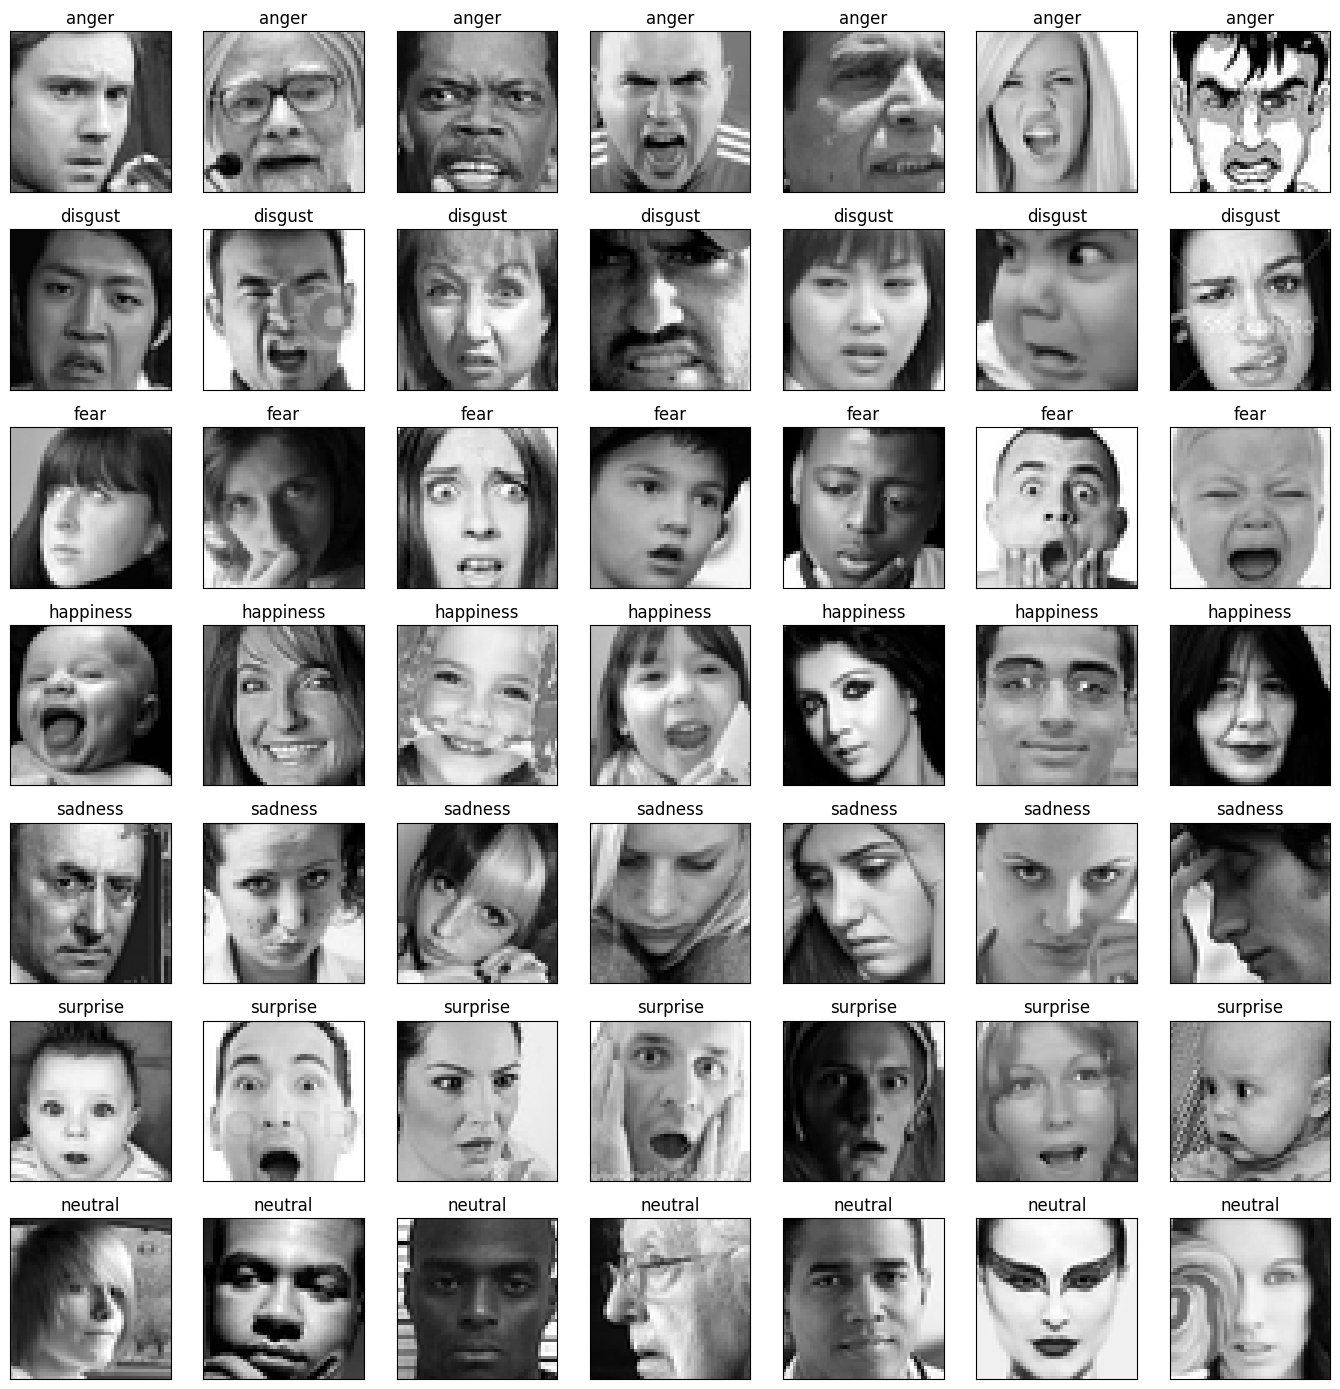

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        pyplot.tight_layout()

In [10]:
# discarding emotions Disgust & fear
used_labels=[3,6,4,0,5]

In [11]:
# discarding emotions Disgust & Suprise to get slightly balanced dataset
used_labels=[3,6,4,2,0]

In [12]:
# Using full original dataset
used_labels=[3,6,4,2,0,5,1]

In [13]:
data = data[data.emotion.isin(used_labels)]
data.shape

(35887, 3)

In [14]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [15]:
img_array.shape

(35887, 48, 48, 1)

In [16]:
from sklearn.preprocessing import OneHotEncoder
LE= LabelEncoder()
image_labels = LE.fit_transform(data.emotion)
image_labels = np_utils.to_categorical(image_labels)
image_labels[5]


array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [17]:
LE.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [18]:
LE_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(LE_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_array, image_labels, test_size=0.1, shuffle=True, stratify=image_labels,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [20]:
X_valid.shape

(3230, 48, 48, 1)

In [21]:
X_train.shape

(29068, 48, 48, 1)

In [22]:
X_test.shape

(3589, 48, 48, 1)

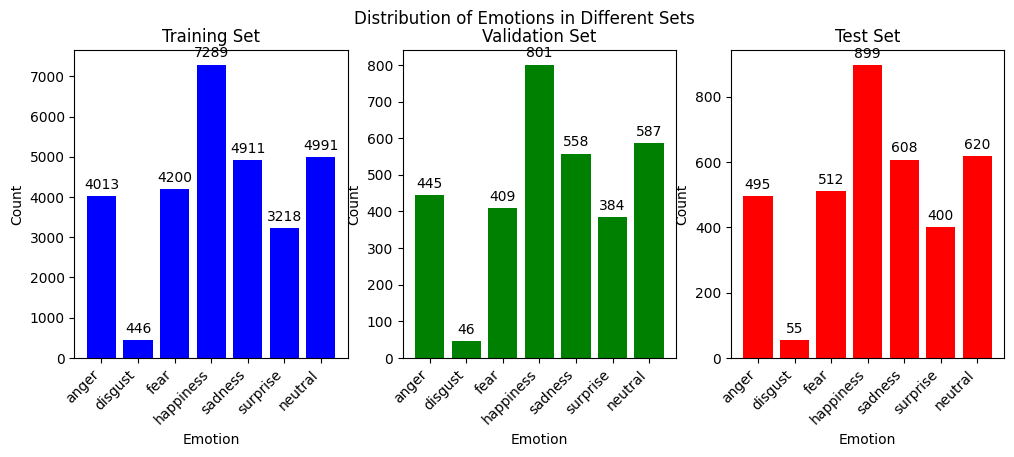

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class labels
class_labels =emotion_labels


# Define the colors to use for each set
set_colors = ['blue', 'green', 'red']

# Define the sets of labels to plot
label_sets = [y_train, y_valid, y_test]
set_names = ['Training Set', 'Validation Set', 'Test Set']

# Get the counts for each set and class
counts = [np.sum(labels, axis=0) for labels in label_sets]

# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Loop over the sets and plot the histograms
for i, ax in enumerate(axs.flat):
    # Create the histogram plot
    bars = ax.bar(class_labels.values(), counts[i], color=set_colors[i])

    # Set the x-axis tick labels to be tilted by 45 degrees
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add the count number on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')
    ax.set_title(set_names[i])

# Set the overall title of the plot
fig.suptitle('Distribution of Emotions in Different Sets')

# # Set the background color of the subplots to white
# plt.rcParams['axes.facecolor'] = 'white'

# # Adjust the spacing between the subplots
# plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


In [24]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [25]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test/255.


In [26]:
def build_net(optim):
    img_input = Input(shape=(img_width, img_height, img_depth))

    Conv1 = Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same',
               kernel_initializer='he_normal')(img_input)
    B1 = BatchNormalization()(Conv1)
    Conv2 = Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same',
               kernel_initializer='he_normal')(B1)
    B2 = BatchNormalization()(Conv2)
    M1 = MaxPooling2D(pool_size=(2,2))(B2)
    D1 = Dropout(0.4)(M1)

    Conv3 = Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(D1)
    B3 = BatchNormalization()(Conv3)
    Conv4 = Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(B3)
    B4 = BatchNormalization()(Conv4)
    M2 = MaxPooling2D(pool_size=(2,2))(B4)
    D2 = Dropout(0.4)(M2)

    Conv5 = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(D2)
    B5 = BatchNormalization()(Conv5)
    Conv6 = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(B5)
    B6 = BatchNormalization()(Conv6)
    M3 = MaxPooling2D(pool_size=(2,2))(B6)
    D3 = Dropout(0.5)(M3)

    x = Flatten()(D3)
    DN1 = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
    B7 = BatchNormalization()(DN1)
    D4 = Dropout(0.6)(B7)

    output = Dense(num_classes, activation='softmax')(D4)

    net = Model(img_input, output)

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()
    return net

In [27]:
"""
Using two callbacks  , one is `early stopping` for avoiding overfitting training data
and another is  `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [28]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

### Plotting Train Test and Validation Sets

In [31]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0   

<ipython-input-31-625fada2be27>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


KeyboardInterrupt: ignored

### Without Augmentation

In [ ]:
# batch_size = 32 #batch size of 32 performs the best.
# epochs = 100
# optims = [
#     optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
#     optimizers.Adam(0.001),
# ]

# model = build_net(optims[1])
# #train without augmentation
# history= model.fit(np.array(X_train), np.array(y_train),
#           batch_size=32,
#           steps_per_epoch=len(X_train) / batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(np.array(X_valid), np.array(y_valid)),
#           shuffle=True,
#           callbacks=callbacks)

In [ ]:
model_70 = model.to_json()
with open("model.70", "w") as json_file:
    json_file.write(model_70)

model.save("model.h5")

# Evaluation On the Best Loaded Model

In [ ]:
loaded_model = tf.keras.models.load_model('/content/model.h5')

In [ ]:
loaded_model.summary()

In [ ]:
predict_x = loaded_model.predict(X_test)
classes_x = np.argmax(predict_x,axis= 1)

In [ ]:
true_class = np.argmax(y_test,axis=1)

In [ ]:
true_class.shape

In [ ]:
classes_x.shape, X_test.shape, y_test.shape

## Plotting Missclassified Samples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels
emotion_labels = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Find misclassified images for each emotion category
misclassified_images = []
for emotion_label in emotion_labels.values():
    # Get indices of misclassified images for the current emotion label
    misclassified_indices = np.where((classes_x != true_class) & (true_class == list(emotion_labels.keys())[list(emotion_labels.values()).index(emotion_label)]))[0]
    if len(misclassified_indices) > 0:
        # Randomly select a misclassified image for the current emotion label
        random_index = np.random.choice(misclassified_indices)
        misclassified_images.append((X_test[random_index], true_class[random_index], classes_x[random_index]))

# Display the misclassified images
fig, axs = plt.subplots(ncols=len(misclassified_images), figsize=(10, 5))

for i, (image, true_label, predicted_label) in enumerate(misclassified_images):
    # Reshape the image from (48, 48, 1) to (48, 48)
    image = image.squeeze()

    # Plot the misclassified image
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'True Label: {emotion_labels[true_label]}\nPredicted Label: {emotion_labels[predicted_label]}', fontsize=7)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels
emotion_labels = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Find correctly classified samples of happiness emotion
correct_happiness_indices = np.where((true_class == 3) & (classes_x == 3))[0]

# Find misclassified samples of happiness emotion
misclassified_happiness_indices = np.where((true_class == 3) & (classes_x != 3))[0]

# Display the correctly classified sample of happiness emotion
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(18, 4))

# Display correctly classified happiness sample
axs[0].imshow(X_test[correct_happiness_indices[0]].squeeze(), cmap='gray')
axs[0].set_title('Correctly Classified Happiness')
axs[0].axis('off')

# Display misclassified samples as other emotions
for i, emotion_label in enumerate(emotion_labels.values()):
    if emotion_label != 'Happiness':
        # Find misclassified samples as the current emotion
        misclassified_indices = np.where((true_class == 3) & (classes_x == list(emotion_labels.keys())[list(emotion_labels.values()).index(emotion_label)]))[0]
        if len(misclassified_indices) > 0:
            # Display a random misclassified sample as the current emotion
            random_misclassified_index = np.random.choice(misclassified_indices)
            axs[i+1].imshow(X_test[random_misclassified_index].squeeze(), cmap='gray')
            axs[i+1].set_title(f'Misclassified as {emotion_label}')
            axs[i+1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels
emotion_labels = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Find correctly classified samples of sadness emotion
correct_sadness_indices = np.where((true_class == 4) & (classes_x == 4))[0]

# Find misclassified samples of sadness emotion
misclassified_sadness_indices = np.where((true_class == 4) & (classes_x != 4))[0]

# Display the correctly classified sample of sadness emotion
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(18, 4))

# Display correctly classified sadness sample
axs[0].imshow(X_test[correct_sadness_indices[0]].squeeze(), cmap='gray')
axs[0].set_title('Correctly Classified as Sadness')
axs[0].axis('off')

# Display misclassified samples as other emotions
for i, emotion_label in enumerate(emotion_labels.values()):
    if emotion_label != 'Sadness':
        # Find misclassified samples as the current emotion
        misclassified_indices = np.where((true_class == 4) & (classes_x == list(emotion_labels.keys())[list(emotion_labels.values()).index(emotion_label)]))[0]
        if len(misclassified_indices) > 0:
            # Display a random misclassified sample as the current emotion
            random_misclassified_index = np.random.choice(misclassified_indices)
            axs[i+1].imshow(X_test[random_misclassified_index].squeeze(), cmap='gray')
            axs[i+1].set_title(f'Misclassified as {emotion_label}')
            axs[i+1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels
emotion_labels = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Find correctly classified samples of surprise emotion
correct_surprise_indices = np.where((true_class == 5) & (classes_x == 5))[0]

# Find misclassified samples of surprise emotion
misclassified_surprise_indices = np.where((true_class == 5) & (classes_x != 5))[0]

# Display the correctly classified sample of surprise emotion
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(18, 4))

# Display correctly classified surprise sample
axs[0].imshow(X_test[correct_surprise_indices[0]].squeeze(), cmap='gray')
axs[0].set_title('Correctly Classified as Surprise')
axs[0].axis('off')

# Display misclassified samples as other emotions
for i, emotion_label in enumerate(emotion_labels.values()):
    if emotion_label != 'Surprise':
        # Find misclassified samples as the current emotion
        misclassified_indices = np.where((true_class == 5) & (classes_x == list(emotion_labels.keys())[list(emotion_labels.values()).index(emotion_label)]))[0]
        if len(misclassified_indices) > 0:
            # Display a random misclassified sample as the current emotion
            random_misclassified_index = np.random.choice(misclassified_indices)
            axs[i+1].imshow(X_test[random_misclassified_index].squeeze(), cmap='gray')
            axs[i+1].set_title(f'Misclassified as {emotion_label}')
            axs[i+1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# from tensorflow import keras
# from keras.utils.vis_utils import plot_model
# from keras.utils import np_utils

# keras.utils.plot_model(model, to_file='model3.png', show_layer_names=True)


## Loss Curves

In [ ]:
sns.set()
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(history.epoch, history.history['accuracy'], label='train')
axes[0].plot(history.epoch, history.history['val_accuracy'], label='valid')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[1].plot(history.epoch, history.history['loss'], label='train')
axes[1].plot(history.epoch, history.history['val_loss'], label='valid')
axes[1].set_title('Loss')
axes[1].legend()

pyplot.tight_layout()
pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


In [ ]:
predict_x = model.predict(X_valid)
classes_x = np.argmax(predict_x,axis= 1)
skplt.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), classes_x,figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != classes_x)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), classes_x))

# The confusion matrix represents how well the model is performing on emotion with higher number of samples, while its performace is slightly worse on emotions with lower number of samples. On the other hand,  some images in emotion Disgust and Angry, Fear and Neutral can easily be misclassified even  by human eye. Facial expression depends on individual as well.


### Confusion Matrix on Test data

In [ ]:
predict_x = loaded_model.predict(X_test)
classes_x = np.argmax(predict_x,axis= 1)
skplt.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), classes_x,figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != classes_x)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), classes_x))

In [ ]:
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Make predictions
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), classes_x, figsize=(7, 7),
                                    title="Confusion Matrix (Emotion Labels)",
                                    text_fontsize='large', cmap='Blues')

# Replace x and y tick labels with emotion names
tick_marks = np.arange(len(emotion_labels))
plt.xticks(tick_marks, list(emotion_labels.values()), rotation=45, fontsize=12)
plt.yticks(tick_marks, list(emotion_labels.values()), fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, classes_x)

correct_pred_per_class = np.diag(cm)
incorrect_pred_per_class = np.sum(cm, axis=1) - np.diag(cm)

print("Correct predictions per class:", correct_pred_per_class)
print("Incorrect predictions per class:", incorrect_pred_per_class)


In [ ]:
np.sum(incorrect_pred_per_class) +np.sum(correct_pred_per_class)

In [ ]:
np.sum(incorrect_pred_per_class)

In [ ]:
np.sum(correct_pred_per_class) / 3589

In [ ]:
np.array(correct_pred_per_class) / (np.array(correct_pred_per_class) + np.array(incorrect_pred_per_class))

In [ ]:
mapper = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "suprise",
    6: "neutral"
}



# We see random samples from emotion Disgust classified as emotion Angry/Neutral, as well as emotion Fear misclassified as Angry/Sad etc

In [ ]:
np.random.seed(2)


random_dis_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)




fig = pyplot.figure(1, (18, 4))

for i, ( disidx, fearidx ) in enumerate(zip(random_dis_imgs, random_fear_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[disidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:dis, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[fearidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:fear, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()





# We see random samples from emotion Sad classified as emotion Angry/Neutral, as well as emotion Neutral classified as Angry/Sad.

In [ ]:
np.random.seed(2)


random_sad_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)




fig = pyplot.figure(1, (18, 4))

for i, ( sadidx, neuidx ) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:neut, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()







In [ ]:
np.random.seed(2)

random_angry_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
# random_happy_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)


fig = pyplot.figure(1, (18, 4))

for i, (fearidx , angryidx ) in enumerate(zip(random_angry_imgs,random_fear_imgs )):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[angryidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:angry, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[fearidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:fear, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()




